<a href="https://colab.research.google.com/github/Kenche-Koushik/Air-Quality-Monitoring-and-Prediction/blob/main/AQI_Prediction_DL_Model_(Station_Level).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step-by-Step Air Quality Index (AQI) Prediction Model (Station-Level)

This notebook provides a complete workflow for building an enhanced deep learning model to predict the Air Quality Index (AQI) at the **individual monitoring station level**. This approach is more granular and accurate than a city-wide average because it learns the unique patterns of each station.

### How to Use This Notebook in Google Colab
1.  **Download Dataset**: From the Kaggle link, download `station_day.csv`.
2.  **Upload to Colab**: When you run the data loading cell, Colab will prompt you to upload the `station_day.csv` file.
3.  **Run Cells**: Execute each code cell sequentially to perform the following steps:
    *   **Setup**: Import necessary libraries.
    *   **Data Loading**: Load the station pollution data (`station_day.csv`).
    *   **Data Cleaning & Preprocessing**: Handle missing values specific to each station.
    *   **Feature Engineering**: Calculate the AQI (our target variable).
    *   **Data Scaling & Splitting**: Prepare the data for the neural network.
    *   **Deep Learning Model Building**: Design and train the neural network.
    *   **Model Evaluation**: Assess model performance.
    *   **Saving the Model & Scaler**: Save the final assets for deployment.

## Step 1: Setup - Importing Libraries

In [ ]:
# Import necessary libraries for data manipulation, analysis, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

# Import libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Import libraries for Deep Learning (TensorFlow and Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

## Step 2: Data Loading

In [ ]:
# Load the dataset from the uploaded file in Google Colab
from google.colab import files
print("Please upload 'station_day.csv'")
uploaded = files.upload()

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('station_day.csv')

print("Shape of the dataframe:", df.shape)
print("\nFirst 5 rows of the dataset:")
display(df.head())

Please upload 'station_day.csv'


Saving station_day.csv to station_day.csv
Shape of the dataframe: (108035, 16)

First 5 rows of the dataset:


,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


## Step 3: Data Cleaning & Preprocessing

In [ ]:
# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Define columns with pollutant data
pollutant_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

# Apply forward fill and backward fill grouped by each unique StationId
df[pollutant_cols] = df.groupby('StationId')[pollutant_cols].transform(lambda x: x.ffill().bfill())

# For any stations that might still have NaNs (if all their data was missing), fill with the global mean
df[pollutant_cols] = df[pollutant_cols].fillna(df[pollutant_cols].mean())

# Drop rows where the essential PM2.5 data is still missing
df.dropna(subset=['PM2.5'], inplace=True)

# Check if there are any remaining missing values
print("Missing values after cleaning:")
display(df.isnull().sum())

Missing values after cleaning:


,0
StationId,0
Date,0
PM2.5,0
PM10,0
NO,0
NO2,0
NOx,0
NH3,0
CO,0
SO2,0


## Step 4: Feature Engineering - AQI Calculation

In [ ]:
# Function to calculate AQI sub-index based on PM2.5
def get_pm25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

# Apply the function to the PM2.5 column to calculate the AQI
df['AQI_calculated'] = df['PM2.5'].apply(get_pm25_subindex)

display(df.head())

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,AQI_calculated
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN,137.866667
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate,171.333333
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate,161.066667
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate,195.866667
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate,113.933333


## Step 5: Data Scaling & Splitting

In [ ]:
# Select the features (pollutants) and the target variable (AQI)
features = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']
target = 'AQI_calculated'

X = df[features]
y = df[target]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")

Training data shape: (86428, 6)
Testing data shape: (21607, 6)


## Step 6: Deep Learning Model Building

In [ ]:
# Define the model architecture
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu')) # Input layer + first hidden layer
model.add(Dense(64, activation='relu')) # Second hidden layer
model.add(Dropout(0.2)) # Dropout layer to prevent overfitting
model.add(Dense(32, activation='relu')) # Third hidden layer
model.add(Dense(1, activation='linear')) # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
print("\nTraining the deep learning model...")
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=64, # Increased batch size for potentially faster training on larger dataset
    validation_split=0.2, # Use 20% of training data for validation
    verbose=1
)
print("Model training complete!")


Training the deep learning model...
Epoch 1/50
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 12201.0840 - mae: 67.0362 - val_loss: 158.4058 - val_mae: 8.9944
Epoch 2/50
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 299.7003 - mae: 11.5631 - val_loss: 10.0269 - val_mae: 2.0808
Epoch 3/50
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 226.5306 - mae: 9.5752 - val_loss: 5.4814 - val_mae: 1.6139
Epoch 4/50
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 219.6958 - mae: 9.3671 - val_loss: 10.4772 - val_mae: 2.4740
Epoch 5/50
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 213.4366 - mae: 9.2465 - val_loss: 9.6855 - val_mae: 2.0489
Epoch 6/50
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 209.3833 - mae: 9.0508 - val_loss: 12.1712 - val_mae: 2.8073
Epoch 7/50
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 210.0617 - mae: 9.0604 - val_loss: 3.2350 - val_mae: 1.1342
Epoch 8/50
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 207.7492 - mae: 8.8846 - val_loss: 7.8

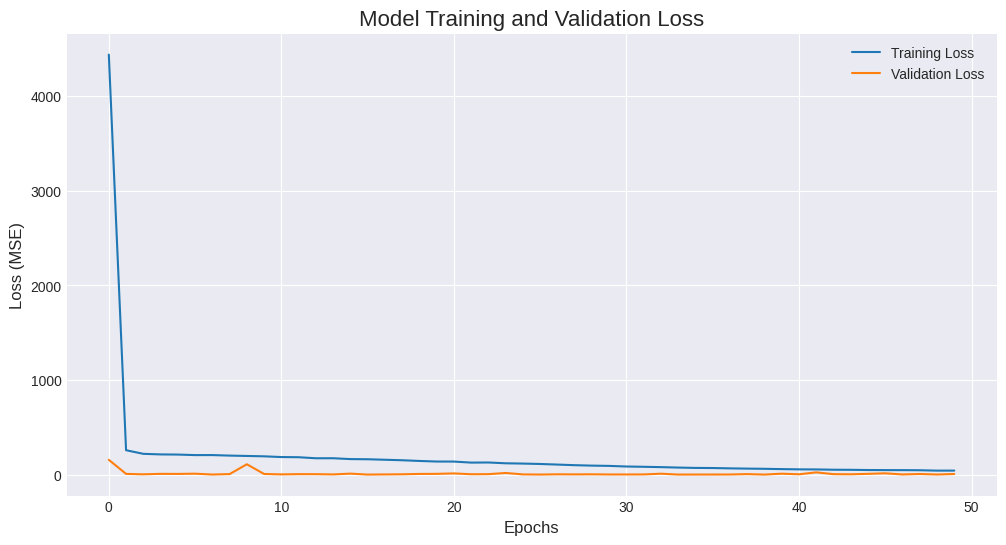

In [ ]:
# Visualize training history (loss)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.show()

## Step 7: Model Evaluation

In [ ]:
# Make predictions on the scaled test data
y_pred = model.predict(X_test_scaled).flatten() # flatten to convert from 2D to 1D array

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Deep Learning Model Performance on Test Data:")
print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

676/676 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Deep Learning Model Performance on Test Data:
R-squared (R2): 0.9995
Mean Absolute Error (MAE): 2.2285
Mean Squared Error (MSE): 8.6854
Root Mean Squared Error (RMSE): 2.9471


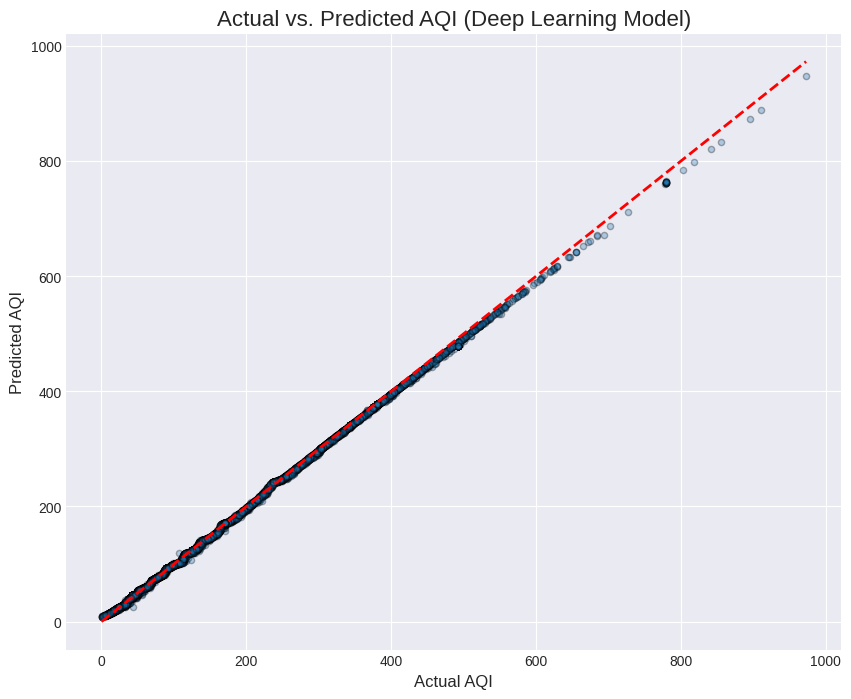

In [ ]:
# Visualize the actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k', s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs. Predicted AQI (Deep Learning Model)', fontsize=16)
plt.xlabel('Actual AQI', fontsize=12)
plt.ylabel('Predicted AQI', fontsize=12)
plt.show()

## Step 8: Saving the Model and Scaler

In [ ]:
# Save the trained model in the Keras H5 format
model_filename = 'aqi_predictor_dl_model_station.h5'
model.save(model_filename)
print(f"Model saved successfully as {model_filename}")

# Save the scaler object using pickle
scaler_filename = 'scaler_station.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
print(f"Scaler saved successfully as {scaler_filename}")

# Download both files from Colab
files.download(model_filename)
files.download(scaler_filename)

Model saved successfully as aqi_predictor_dl_model_station.h5
Scaler saved successfully as scaler_station.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>